In [95]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [120]:
phase =  np.loadtxt("../Questions/data/train_7.csv")
data = (phase-0.5) * 2.1 * np.pi / 180 * 2
np.savetxt("../Questions/data/phase_7.csv", data, delimiter=",", fmt="%.8f")

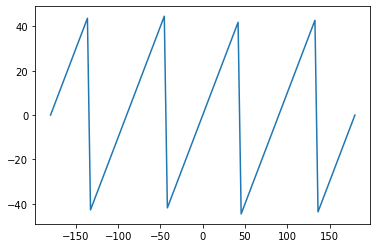

In [19]:
# (1)
def jones_pol(phi):
    return np.array([[np.cos(-phi)**2, np.sin(-2*phi)/2],
              [np.sin(-2*phi)/2, np.sin(-phi)**2]])

phi = np.linspace(-np.pi, np.pi, 100)

r_hat = np.array([1,1.j]).reshape((-1, 1))
l_hat = np.array([1,-1.j]).reshape((-1, 1))

rcp = r_hat * np.exp(1.j*phi) / np.sqrt(2)
lcp = l_hat * np.exp(-1.j*phi) / np.sqrt(2)

Ein = rcp + lcp

T0 = jones_pol(0)
T45 = jones_pol(np.pi/4)
T90 = jones_pol(np.pi/2)
T135 = jones_pol(3*np.pi/4)

E0 = T0 @ Ein
I0 = np.abs(E0[0,:])**2/2 + np.abs(E0[1,:])**2/2
E45 = T45 @ Ein
I45 = np.abs(E45[0,:])**2/2 + np.abs(E45[1,:])**2/2
E90 = T90 @ Ein
I90 = np.abs(E90[0,:])**2/2 + np.abs(E90[1,:])**2/2
E135 = T135 @ Ein
I135 = np.abs(E135[0,:])**2/2 + np.abs(E135[1,:])**2/2

S1 = I0-I90
S2 = I45-I135
phi_F = np.arctan(S2/S1)/2
plt.plot(np.degrees(phi), np.degrees(phi_F))
plt.savefig("../Questions/images/Q8_1.png")

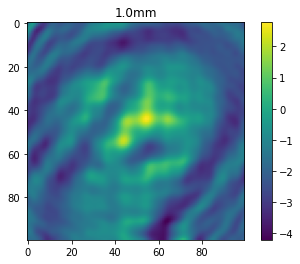

In [124]:
# (2)
def angular_spectrum(g0, wavelength, z, d):
    pad_width = math.ceil(g0.shape[1]/2)
    pad_height = math.ceil(g0.shape[0]/2)
    padded = np.pad(g0, [[pad_height, pad_height],[pad_width, pad_width]])
    padded_width = padded.shape[1]
    padded_height = padded.shape[0]
    fft_image = np.fft.fft2(padded)
    u = np.fft.fftfreq(padded_width, d)
    v = np.fft.fftfreq(padded_height, d)
    UU, VV = np.meshgrid(u, v)
    w = np.where(UU**2 + VV**2 <= 1/wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
    h = np.exp(1.0j * 2.0*np.pi * w * z)
    du = 1.0/(padded_width * d)
    dv = 1.0/(padded_height * d)
    u_lim = 1.0/(wavelength * np.sqrt((2.0 * du * z)**2 + 1.0))
    v_lim = 1.0/(wavelength * np.sqrt((2.0 * dv * z)**2 + 1.0))
    u_filter = np.where(np.abs(UU/(2*u_lim)) < 1/2, 1, 0)
    v_filter = np.where(np.abs(VV/(2*v_lim)) < 1/2, 1, 0)
    h_lim = h * u_filter * v_filter
    gz = np.fft.ifft2(fft_image * h_lim)
    g_crop = gz[pad_height:pad_height + g0.shape[0], pad_width:pad_width + g0.shape[1]]
    return g_crop


phase = np.loadtxt("../Questions/data/phase_7.csv", delimiter=",")
r_hat = np.array([1,1.j])
l_hat = np.array([1,-1.j])

z0 = 0
rcp = np.ones([100, 100,2]) * r_hat * np.exp(1.j * z0) / np.sqrt(2)
lcp = np.ones([100, 100,2]) * l_hat * np.exp(-1.j * z0) / np.sqrt(2)

rcp_mo = np.stack([rcp[:,:,0] * np.exp(1.j * phase), rcp[:,:,1] * np.exp(1.j * phase)], axis=-1)
lcp_mo = np.stack([lcp[:,:,0] * np.exp(-1.j * phase), lcp[:,:,1] * np.exp(-1.j * phase)], axis=-1)

wavelength = 532.e-9
d = 1.e-6
z = 1.0e-3
rcp_prop = np.stack([angular_spectrum(rcp_mo[:,:,0], wavelength, z, d),
                     angular_spectrum(rcp_mo[:,:,1], wavelength, z, d)], axis=-1)
lcp_prop = np.stack([angular_spectrum(lcp_mo[:,:,0], wavelength, z, d),
                     angular_spectrum(lcp_mo[:,:,1], wavelength, z, d)], axis=-1)

Etot = rcp_prop + lcp_prop
E0 = T0 @ np.expand_dims(Etot, -1)
E45 = T45 @ np.expand_dims(Etot, -1)
E90 = T90 @ np.expand_dims(Etot, -1)
E135 = T135 @ np.expand_dims(Etot, -1)

I0 = np.abs(E0[:,:,0,:])**2/2 + np.abs(E0[:,:,1,:])**2/2
I45 = np.abs(E45[:,:,0,:])**2/2 + np.abs(E45[:,:,1,:])**2/2
I90 = np.abs(E90[:,:,0,:])**2/2 + np.abs(E90[:,:,1,:])**2/2
I135 = np.abs(E135[:,:,0,:])**2/2 + np.abs(E135[:,:,1,:])**2/2

S1 = I0 - I90
S2 = I45 - I135

phi_F = np.arctan(S2/S1)/2
plt.imshow(phi_F * 180 / np.pi)
plt.colorbar()
plt.title("1.0mm")
plt.savefig("../Questions/images/Q8_6.png")